In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import IPython
import IPython.display

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the data
raw_data = pd.read_csv('delanteros.csv', sep=';',encoding='latin-1')
# Deleting the NULL values
raw_data = raw_data.dropna(subset = ['Tiros'])
raw_data = raw_data.dropna(subset = ['Tiros a puerta'])

# filtering out the last 2 columns
raw_data = raw_data[['Nombre','Fecha','Jornadas','Titular','Minutos','Goles','Asistencias','Tiros','Tiros a puerta']]

forecast_data = raw_data

forecast_data = forecast_data[~forecast_data['Nombre'].isin(['Lucas Boyé', 'Luis Javier Suárez', 'Alexander Isak', 'Rafa Mir'])]

# Limiting the columns we need
forecast_data = forecast_data[['Nombre','Jornadas','Goles']]

#Original Data
original = forecast_data[forecast_data['Nombre'] == 'Karim Benzema']
original1 = original[['Jornadas', 'Goles']]

# set the Jornada into index
original1.set_index('Jornadas', inplace=True)
original1


,Goles
Jornadas,
1,0
2,2
3,2
4,0
5,0
...,...
114,0
115,1
116,0


In [3]:
original1_df1 = original1.diff(periods=1)
original1_df1.dropna(inplace=True)

In [11]:
column_indices = {name: i for i, name in enumerate(original1_df1.columns)}

n = len(original1_df1)
train_df = original1_df1[0:90]
val_df = original1_df1[90:110]
test_df = original1_df1[110:]

num_features = original1_df1.shape[1]
print(num_features)

1


In [5]:
train_df

,Goles
Jornadas,
2,2.0
3,0.0
4,-2.0
5,0.0
6,0.0
...,...
87,-1.0
88,0.0
89,0.0


In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [7]:
train_df

,Goles
Jornadas,
2,1.868207
3,0.000000
4,-1.868207
5,0.000000
6,0.000000
...,...
87,-0.934103
88,0.000000
89,0.000000


In [6]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [7]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Goles'])
w1

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Goles']

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [9]:
train_df[:w1.total_window_size]
train_df[8:8+w1.total_window_size]

,Goles
Jornadas,
10,0.0
11,0.0
12,1.0
13,-1.0
14,0.0
15,0.0
16,1.0


In [10]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[8:8+w1.total_window_size]),
                           np.array(train_df[15:15+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')
example_inputs

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


<tf.Tensor: shape=(3, 6, 1), dtype=float64, numpy=
array([[[ 2.],
        [ 0.],
        [-2.],
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 1.],
        [-1.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [-1.],
        [ 0.],
        [ 0.],
        [ 2.],
        [-1.]]])>

In [31]:
w1.example = example_inputs, example_labels

In [12]:
def plot(self, model=None, plot_col='Goles', max_subplots=6):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normalizado]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Jornada')

WindowGenerator.plot = plot

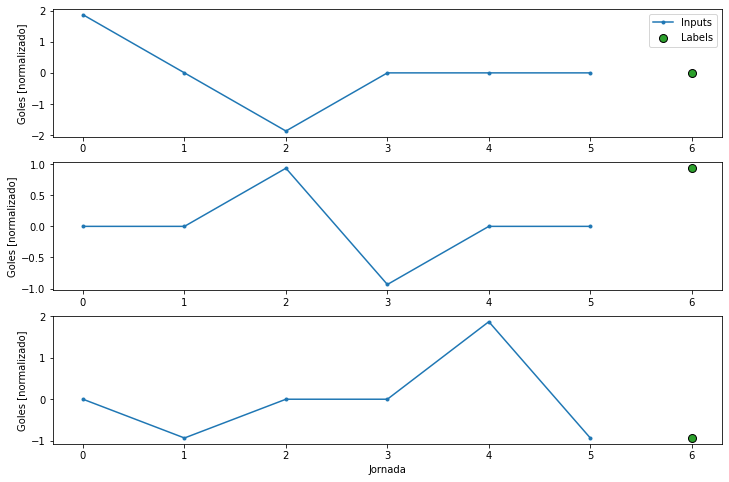

In [33]:
w1.plot()

In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [14]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [36]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [37]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [38]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Goles'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Goles']

In [39]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [43]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [44]:
baseline = Baseline(label_index=column_indices['Goles'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 162ms/step - loss: 3.0769 - mean_absolute_error: 1.4257


In [45]:
wide_window = WindowGenerator(
    input_width=4, label_width=4, shift=1,
    label_columns=['Goles'])

wide_window

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): ['Goles']

In [46]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 4, 1)
Output shape: (32, 4, 1)


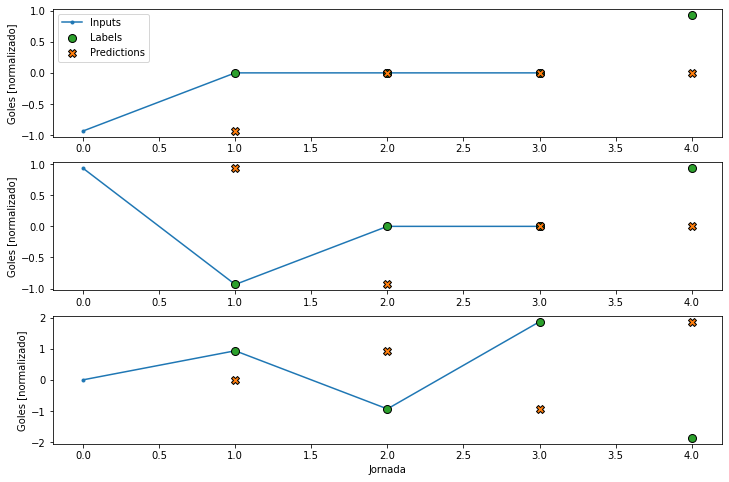

In [47]:
wide_window.plot(baseline)

In [48]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [49]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [15]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [51]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
3/3 [==============================] - 0s 60ms/step - loss: 0.9125 - mean_absolute_error: 0.6880 - val_loss: 1.2865 - val_mean_absolute_error: 0.8418
Epoch 2/20
3/3 [==============================] - 0s 30ms/step - loss: 0.9100 - mean_absolute_error: 0.6878 - val_loss: 1.2845 - val_mean_absolute_error: 0.8421
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 0.9077 - mean_absolute_error: 0.6876 - val_loss: 1.2825 - val_mean_absolute_error: 0.8424
Epoch 4/20
3/3 [==============================] - 0s 33ms/step - loss: 0.9057 - mean_absolute_error: 0.6874 - val_loss: 1.2805 - val_mean_absolute_error: 0.8427
Epoch 5/20
3/3 [==============================] - 0s 30ms/step - loss: 0.9031 - mean_absolute_error: 0.6870 - val_loss: 1.2785 - val_mean_absolute_error: 0.8430
Epoch 6/20
3/3 [==============================] - 0s 33ms/step - loss: 0.9011 - mean_absolute_error: 0.6869 - val_loss: 1.2765 - val_mean_absolute_error: 0.8433
Epoch 7/20
3/3 [==================

In [52]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 4, 1)
Output shape: (32, 4, 1)


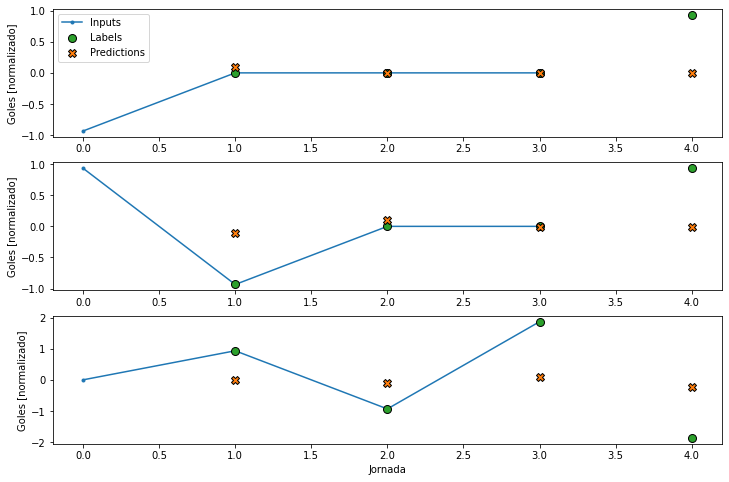

In [53]:
wide_window.plot(linear)

In [54]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
3/3 [==============================] - 1s 82ms/step - loss: 0.9637 - mean_absolute_error: 0.7024 - val_loss: 1.2946 - val_mean_absolute_error: 0.8419
Epoch 2/20
3/3 [==============================] - 0s 31ms/step - loss: 0.9024 - mean_absolute_error: 0.6873 - val_loss: 1.2440 - val_mean_absolute_error: 0.8471
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 0.8512 - mean_absolute_error: 0.6804 - val_loss: 1.2058 - val_mean_absolute_error: 0.8509
Epoch 4/20
3/3 [==============================] - 0s 32ms/step - loss: 0.8089 - mean_absolute_error: 0.6687 - val_loss: 1.1766 - val_mean_absolute_error: 0.8526
Epoch 5/20
3/3 [==============================] - 0s 40ms/step - loss: 0.7766 - mean_absolute_error: 0.6607 - val_loss: 1.1542 - val_mean_absolute_error: 0.8536
Epoch 6/20
3/3 [==============================] - 0s 36ms/step - loss: 0.7546 - mean_absolute_error: 0.6528 - val_loss: 1.1361 - val_mean_absolute_error: 0.8535
Epoch 7/20
3/3 [==================

In [16]:
CONV_WIDTH = 4  #4 match before predict
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Goles'])

conv_window

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [4]
Label column name(s): ['Goles']

Text(0.5, 1.0, 'Given 4 matchs of inputs, predict 1 hour into the future.')

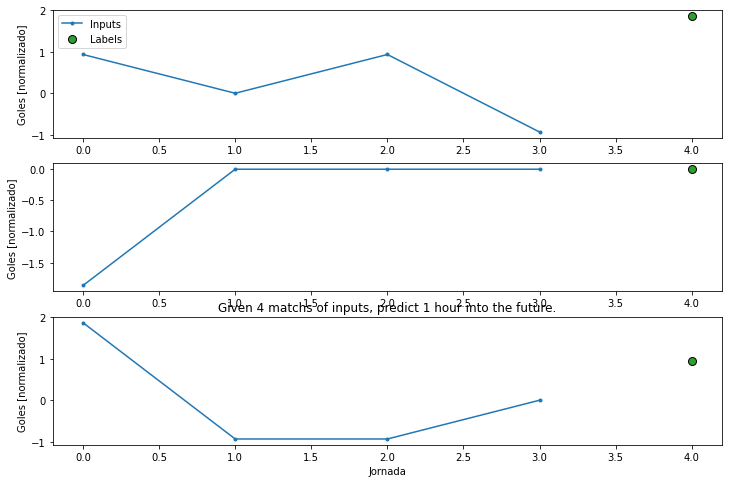

In [56]:
conv_window.plot()
plt.title("Given 4 matchs of inputs, predict 1 hour into the future.")

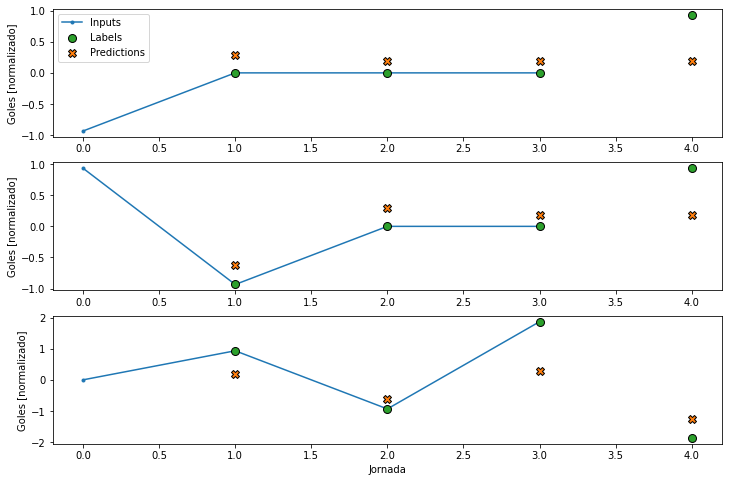

In [57]:
wide_window.plot(dense)

In [58]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [59]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 4, 1)
Output shape: (32, 1, 1)


In [60]:
history = compile_and_fit(multi_step_dense, conv_window)
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 53ms/step - loss: 1.3255 - mean_absolute_error: 0.9190


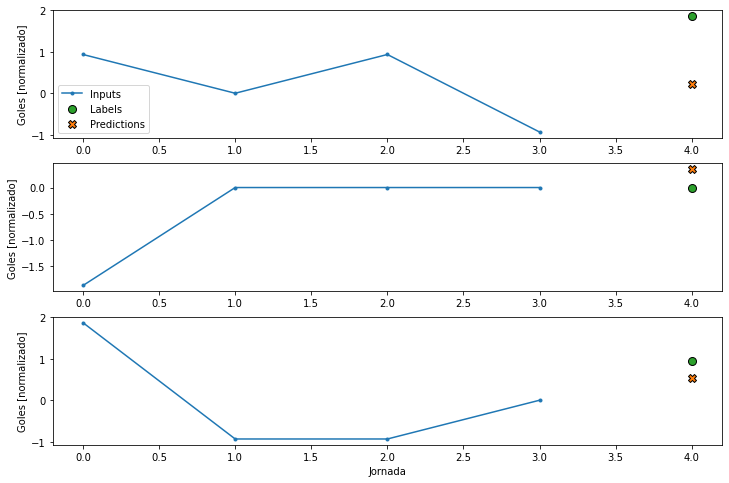

In [61]:
conv_window.plot(multi_step_dense)

In [62]:
'''El principal inconveniente de este enfoque es que el modelo resultante solo se puede ejecutar 
en ventanas de entrada de exactamente esta forma.'''
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 4, 1)
Output shape: (32, 1, 1)


In [17]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [18]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 4, 1)
Output shape: (32, 1, 1)


In [20]:
history = compile_and_fit(conv_model, conv_window)
val_performance = {}
performance = {}
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 99ms/step - loss: 1.2928 - mean_absolute_error: 0.9457


In [66]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 4, 1)
Labels shape: (32, 4, 1)
Output shape: (32, 1, 1)


In [21]:
LABEL_WIDTH = 4
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Goles'])

wide_conv_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [4 5 6 7]
Label column name(s): ['Goles']

In [68]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 7, 1)
Labels shape: (32, 4, 1)
Output shape: (32, 4, 1)


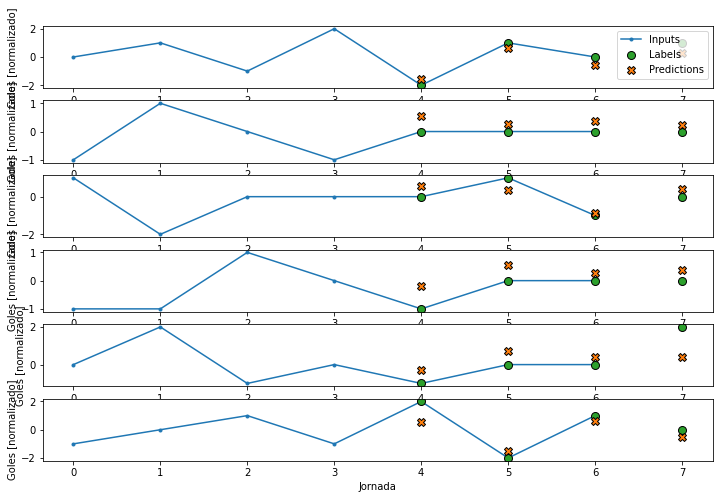

In [22]:
wide_conv_window.plot(conv_model)

In [70]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [71]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 4, 1)
Output shape: (32, 4, 1)


In [72]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 48ms/step - loss: 0.9390 - mean_absolute_error: 0.7848


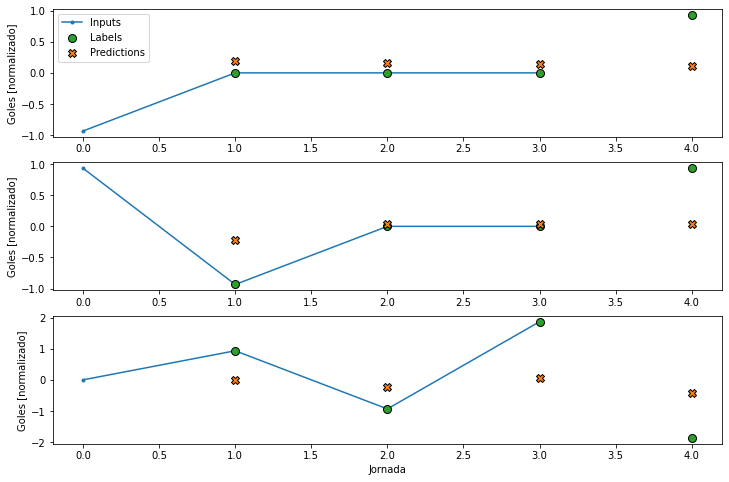

In [73]:
wide_window.plot(lstm_model)

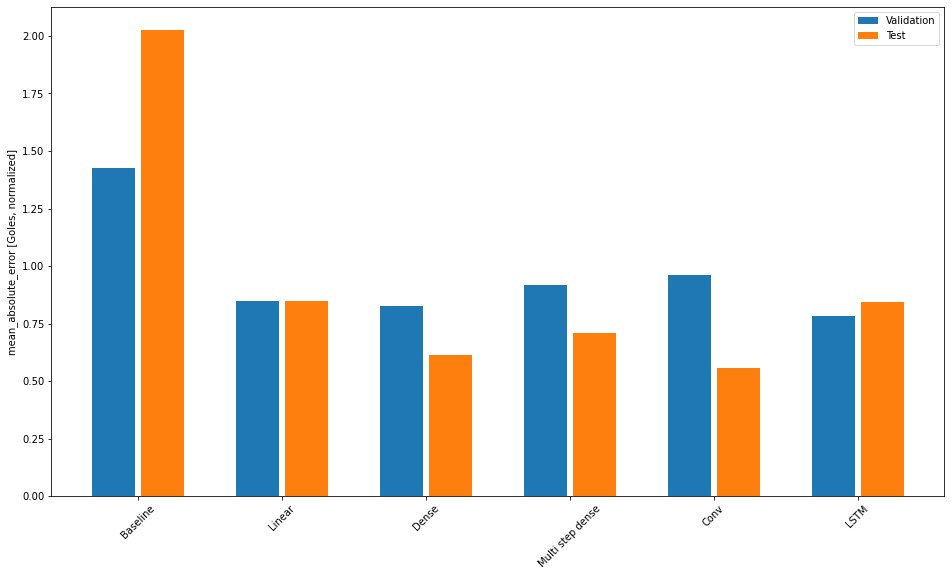

In [74]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Goles, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [75]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 2.0239
Linear      : 0.8470
Dense       : 0.6146
Multi step dense: 0.7094
Conv        : 0.5593
LSTM        : 0.8428
